# Lab Three: Clustering

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our data set consists of over 5 million rows of flight information in the domestic United States for the year of 2015. In order to optimize our modeling time, we have narrowed the scope of our classification tasks to the Dallas area only (Dallas Love Field and DFW airports). 

## Rubric

### [Business Understanding](#Business-Understanding) (10 points total)

- [10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

### [Data Understanding](#Data-Understanding) (20 points total)

- [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?
- [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### [Modeling and Evaluation](#Modeling-and-Evaluation) (50 points total)

Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

#### Option A: Cluster Analysis

- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

### [Deployment](#Deployment) (10 points total)

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

### [Exceptional Work](#Exceptional-Work) (10 points total)

You have free reign to provide additional analyses or combine analyses.

# Business Understanding
Jump to [top](#Rubric)

# Data Understanding
Jump to [top](#Rubric)

The initial data pre-processing has already been covered in Labs 1, 2, and the Mini-Lab. Here we have collapsed our code as much as possible.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from datetime import datetime
import altair as alt
import datetime

# Machine learning
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Subset to DFW Area
df = df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL')]

### Create New Variables

The data contains several timestamp and continuous variables that add additional complexity, and several models cannot run with timestamp data. In order to simplify the data, we created buckets to analyze similar attributes together.

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, `ARRIVAL_TIME`, and `SCHEDULED_ARRIVAL` into buckets based on their timestamp.

    Overnight: 12:00am - 5:59am
    Morning: 6:00am - 11:59am
    Afternoon: 12:00pm - 5:59pm
    Evening: 6:00pm - 11:59pm

[Flight] `DISTANCE` is also divided into buckets.

    Short: 1-99 miles
    Medium: 100-999 miles
    Long: 1,000+ miles

In [5]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 600, 1200, 1800, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'].astype(float), 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'].astype(float), 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)

# Look at our data with the buckets
pd.set_option('display.max_columns', None)
df.head()

### Process Dates & Time

In [8]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

# Creating a function to change the way of representation of time in the column
def fun_format_time(hours):
        if hours == 2400:
            hours = 0
        else:
            hours = "{0:04d}".format(int(hours))
            Hourmin = datetime.time(int(hours[0:2]), int(hours[2:4]))
            return Hourmin

In [10]:
# Define the time columns
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME",
        "WHEELS_ON",
        "WHEELS_OFF"]

# Convert times to float in order to correctly process them through the function
df[cols] = df[cols].astype(float)

# Run times through the new function
# Code adapted from: https://stackoverflow.com/questions/35232705/how-to-test-for-nans-in-an-apply-function-in-pandas
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['DEPARTURE_TIME']      = df['DEPARTURE_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['SCHEDULED_ARRIVAL']   = df['SCHEDULED_ARRIVAL'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['ARRIVAL_TIME']        = df['ARRIVAL_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_ON']           = df['WHEELS_ON'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_OFF']          = df['WHEELS_OFF'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)

# Combine date & time for departure and arrival
# Source: https://stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-python-pandas
df['SCHEDULED_DEPARTURE_DT'] = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_DEPARTURE'].astype(str))
df['SCHEDULED_ARRIVAL_DT']   = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_ARRIVAL'].astype(str))

### Append Dallas-Area Weather

In [17]:
# Read in the data
import datetime
weather = pd.read_csv('../Data/dfw_weather.csv')
weather['dt_iso'] = weather['dt_iso'].astype(str)

# Remove "+0000 UTC"
weather['dt_iso_update'] = weather['dt_iso'].str.split('+').str[0]

# Convert new column to a datetime type
weather['date_time'] =  pd.to_datetime(weather['dt_iso_update'], format='%Y-%m-%d %H:%M')

weather['date_time'] = weather['date_time'].dt.round('30min')  
df['SCHEDULED_DEPARTURE_DT'] = df['SCHEDULED_DEPARTURE_DT'].dt.round('30min')

df = pd.merge(df, weather, left_on='SCHEDULED_DEPARTURE_DT', right_on='date_time')

# Remove unnecessary columns from weather data
col_to_drop = ['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'feels_like', 'temp_min', 'temp_max',
              'sea_level', 'grnd_level', 'dt_iso_update', 'weather_icon', 'weather_description', 'date_time']
df = df.drop(columns = col_to_drop)

### Missing Values

In [26]:
# Remove non-critical columns WHEELS_ON and WHEELS_OFF
df = df.drop(['WHEELS_ON','WHEELS_OFF'], axis=1)

# Add category
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].cat.add_categories(['N'])
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].cat.add_categories(['N'])

# Fill missing values with 'N' for 'N/A'
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].fillna('N')
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].fillna('N')

# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Drop remaining missing values and check total cancels left
df = df.dropna()

# Delete date columns ahead of modeling
df = df.drop(columns = ['FLIGHT_DATE', 'SCHEDULED_DEPARTURE_DT', 'SCHEDULED_ARRIVAL_DT'])

# Convert back to string
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(str)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(str)

# Remove colons
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.str.replace(r'\D+', '')
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.str.replace(r'\D+', '')

# Convert to float
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(int)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(int)

### Log Transformations

In [35]:
print("Min DEPARTURE_DELAY", min(df["DEPARTURE_DELAY"]))
print("Min ARRIVAL_DELAY", min(df["ARRIVAL_DELAY"]))
print("Min DISTANCE", min(df["DISTANCE"]))
print("Min TAXI_IN", min(df["TAXI_IN"]))
print("Min ELAPSED_TIME", min(df["ELAPSED_TIME"]))
print("Min AIR_TIME", min(df["AIR_TIME"]))

Min DEPARTURE_DELAY -24.0
Min ARRIVAL_DELAY -56.0
Min DISTANCE 89
Min TAXI_IN 0.0
Min ELAPSED_TIME 0.0
Min AIR_TIME 0.0


In [36]:
# Log transformation keeping the 0 in the data sets. Because we have negative values, need to offset to make minimum
# equal to zero and not a negative number. For the other vars, no need to run lambda function as min > 0 which improves
# run time
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log(i + 24) if i != -24 else 0) 
df["ARRIVAL_DELAY_log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log(i + 56) if i != -56 else 0)
df["DISTANCE_log"]        = np.log(df["DISTANCE"])
df["TAXI_IN_log"]         = np.log1p(df["TAXI_IN"])
df["ELAPSED_TIME_log"]    = np.log1p(df["ELAPSED_TIME"])
df["AIR_TIME_log"]        = np.log1p(df["AIR_TIME"])

### Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:

- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have AIRLINE_CODE which is the same information

In [38]:
col_to_drop1 = ['YEAR','AIRLINE']
df = df.drop(columns = col_to_drop1)

### Encoding

In [41]:
# Filter out instances where a tail number appears less than 5 times
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]

# Encode Destination Airport & Tail Number
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['DESTINATION_AIRPORT_encode'] = labelencoder.fit_transform(df['DESTINATION_AIRPORT'])
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)
df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop2 = ['TAIL_NUMBER','DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop2)

# One-hot encode categorical columns
categorical_columns = ['AIRLINE_CODE', 'CANCELLATION_REASON', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME',
                       'DISTANCE_BUCKET', 'weather_main', 'ORIGIN_AIRPORT']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns, drop_first = True)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

N906EV    786
N902EV    772
N905EV    769
N904EV    757
N903EV    752
         ... 
N443UA      5
N16713      5
N360NW      5
N7830A      5
N12924      5
Name: TAIL_NUMBER, Length: 2660, dtype: int64


In [48]:
# Scheduled time needs to be int
df_OHE['SCHEDULED_TIME'] = df_OHE['SCHEDULED_TIME'].astype(int)

### Flight Delay Response Variable

Here, we create our second classification response variable for the departure delay. We want to predict which departure delay group a flight is expected to be in based on the information and data we have.

We group the data in the following way:
- EARLY is defined as `0` and is any value where the `DEPARTURE_DELAY` is < 0.
- ON-TIME is defined as `1` and is any value where 0 <= `DEPARTURE_DELAY` <= 10
- LATE is defined as `2` and is any value where 11 <= `DEPARTURE_DELAY` <= 30
- VERY LATE is defined as `3` and is any value where 31 <= `DEPARTURE_DELAY` <= 60
- EXTREMELY LATE is defined as `4` and is any value where `DEPARTURE_DELAY` >= 61

In [49]:
# Add response variable bucket for delay time for departure
# 0 is Early (negative time)
# 1 is On_Time or between 0 and 10 minutes late
# 2 is Late (between 11 and 30 min late)
# 3 is very late (between 31 and 60 min late)
# 4 is extremely late (over 61 min late)

delay_labels = ['0', '1', '2', '3', '4']
delay_bins   = [-np.inf, -1, 10, 30, 60, np.inf]
df_OHE['DELAY_BUCKET'] = pd.cut(df_OHE['DEPARTURE_DELAY'],
                               bins=delay_bins,
                               labels=delay_labels)

#check counts by bucket
df_OHE['DELAY_BUCKET'].value_counts()

0    99535
1    50033
2    24784
3    13854
4    13030
Name: DELAY_BUCKET, dtype: int64

In [51]:
# Convert from category to int
df_OHE['DELAY_BUCKET'] = df_OHE['DELAY_BUCKET'].astype(int)

# Drop unnecessary columns
col_to_drop3 = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']
df_OHE = df_OHE.drop(columns = col_to_drop3)

## 1.9 Delay and Cancel Data set creation

In [53]:
# Make a copy of our data for each new set
df_delay = df_OHE

### 1.9.1 Delay Correlations/Feature Removal

We can remove several variables for our delay bucket group. We will filter out any cancelled flights, as these are not delayed. Then we can also remove `CANCELLED` and our `CANCELLATION_REASON` encoded columns. Because we don't know whether or not the flight will be delayed prior to the analysis, we will also remove `ACTUAL_ARRIVAL_TIME` and `ACTUAL_DEPARTURE_TIME` and all of of our other delay time related columns.

In [54]:
# Filter out cancelled flights
df_delay = df_delay[df_delay.CANCELLED == 0]

col_to_drop4 = ['CANCELLED', 
                'CANCELLATION_REASON_B', 
                'CANCELLATION_REASON_C', 
                'CANCELLATION_REASON_N', 
                'ACTUAL_DEPARTURE_TIME_morning', 
                'ACTUAL_DEPARTURE_TIME_afternoon', 
                'ACTUAL_DEPARTURE_TIME_evening',
                'ACTUAL_DEPARTURE_TIME_N',
                'ACTUAL_ARRIVAL_TIME_morning',
                'ACTUAL_ARRIVAL_TIME_afternoon',
                'SCHEDULED_DEPARTURE',
                'SCHEDULED_ARRIVAL',
                'AIR_SYSTEM_DELAY',
                'SECURITY_DELAY', 
                'ACTUAL_ARRIVAL_TIME_evening',
                'ACTUAL_ARRIVAL_TIME_N',
                'AIRLINE_DELAY', 
                'LATE_AIRCRAFT_DELAY', 
                'WEATHER_DELAY', 
                'DELAYED', 
                'DEPARTURE_DELAY_log',
                'ARRIVAL_DELAY_log', 
                'ELAPSED_TIME_log', 
                'DEPARTED', 
                'ARRIVED',
                'TAXI_IN_log',
                'AIR_TIME_log']

df_delay = df_delay.drop(columns = col_to_drop4)

In [55]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# sns.set(style = "darkgrid") # one of the many styles to plot using

# f, ax = plt.subplots(figsize = (20, 20))

# # Create heatmap
# sns.heatmap(df_delay.corr(), cmap=cmap, annot = True)

We have too many features for a correlation matrix plot to be interpretable. Let's print out the variables that have a correlation greater than 0.8.

In [56]:
# Create correlation matrix with absolute values only
corr_matrix_abs = df_delay.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

['DISTANCE_log', 'DISTANCE_BUCKET_Long', 'ORIGIN_AIRPORT_DFW']


In [57]:
col_to_drop7 = ['DISTANCE_log', 'DIVERTED']

df_delay = df_delay.drop(columns = col_to_drop7)

We decided to drop `DISTANCE_log` and `DIVERTED` from our data set. This is because `DISTANCE_log` is correlated to `DISTANCE_BUCKET_Long` and `DIVERTED` has no relevance to the departure delay time. We do not remove `ORIGIN_AIRPORT_DFW` as it is deemed an important variable for our modeling.

The delay data set contains basic flight information from our original data plus weather data for the appropriate date & time of each flight, encoded variables for `DESTINATION_AIRPORT` and `TAIL_NUMBER`, and one-hot encoded airline codes.
Newly created variables included buckets for the flight’s scheduled departure and arrival times (morning, afternoon, and evening), distance (medium and long), and a response variable `DELAY_BUCKET` that groups delay times by length of delay in minutes.
- **Early** is defined as 0 and is any value where the `DEPARTURE_DELAY` is < 0.
- **On-Time** is defined as 1 and is any value where 0 <= `DEPARTURE_DELAY` <= 10
- **Late** is defined as 2 and is any value where 11 <= `DEPARTURE_DELAY` <= 30
- **Very Late** is defined as 3 and is any value where 31 <= `DEPARTURE_DELAY` <= 60
- **Extremely Late** is defined as 4 and is any value where `DEPARTURE_DELAY` >= 61

In [65]:
# # Save data
#df_cancel.to_csv('../Data/df_cancel.csv', index=False)
#df_delay.to_csv('../Data/df_delay.csv', index=False)

In [66]:
# # # Load data from here to save time
# df_cancel = pd.read_csv('../Data/df_cancel.csv')
# df_delay = pd.read_csv('../Data/df_delay.csv')

# Modeling and Evaluation
Jump to [top](#Rubric)

Next we will split our delay data, but first, let's look at the distribution of the buckets.

In [78]:
# Percentages of each delay bucket
df_delay['DELAY_BUCKET'].value_counts() / len(df_delay) * 100

0    50.899245
1    22.679274
2    12.673802
3     7.084524
4     6.663155
Name: DELAY_BUCKET, dtype: float64

In [79]:
df_delay.shape

(195553, 50)

In [80]:
df_delay['DELAY_BUCKET'].value_counts()

0    99535
1    44350
2    24784
3    13854
4    13030
Name: DELAY_BUCKET, dtype: int64

It appears that half of our data in bucket `0` reflects flights that departed early (negative delay value in the data set). This was a surprisingly high value. How did the rest of the buckets break down?

- 22.7% departed on-time or between 1 and 10 minutes late
- 12.7% departed late (between 11 and 30 min)
- 7.1% departed very late (between 31 and 60 min)
- 6.7% departed extremely late (over 61 min)

In [81]:
# Create X and y for delay data set
if 'DELAY_BUCKET' in df_delay:
    y_del = df_delay['DELAY_BUCKET'].values
    X_del = df_delay.iloc[:,:-1].values

In [82]:
print(X_del.shape)
print(y_del.shape)

(195553, 49)
(195553,)


#### 4.2.1 Undersampling

Due to our class imbalance, we will create a data set that undersamples based on our majority class which is the `0` bucket.

In [83]:
# Source: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

# Define undersample strategy
undersample = RandomUnderSampler(sampling_strategy = 'majority', random_state = 42)

# Fit and apply the transform
X_del_under, y_del_under = undersample.fit_resample(X_del, y_del)

In [84]:
print(X_del_under.shape)
print(y_del_under.shape)

(109048, 49)
(109048,)


In [85]:
# Summarize the new class distribution
counter = Counter(y_del_under)
print(counter)

Counter({1: 44350, 2: 24784, 3: 13854, 0: 13030, 4: 13030})


After undersampling, our classes broke down as follows:

- Class 0: 13,030
- Class 1: 33,546
- Class 2: 24,784 
- Class 3: 13,854
- Class 4: 13,030

#### 4.2.2 Oversampling Using SMOTE

We know that our delay data set is relatively balanced when it comes to flights that departed early vs. all the other groups together. Since the data between the classes is imbalanced, we'll transform the data using SMOTE (**S**ynthetic **M**inority **O**versampling **TE**chnique) and see if that returns better performance. This code is adapted from [Machine Learning Mastery](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

In [86]:
# Oversample using SMOTE
oversample = SMOTE()
X_del_smote, y_del_smote = oversample.fit_resample(X_del, y_del)

In [87]:
print(X_del_smote.shape)
print(y_del_smote.shape)

(497675, 49)
(497675,)


In [88]:
# Summarize the new class distribution
counter = Counter(y_del_smote)
print(counter)

Counter({4: 99535, 1: 99535, 0: 99535, 2: 99535, 3: 99535})


Using SMOTE, all of our classes now have 110,339 observations in them. 

#### 4.2.3 Stratified Shuffle Split

Below we will perform Stratified Shuffle Split to create three train/test splits for modelling:
1. Split on the original data
2. Split on undersampled data
3. Split on SMOTE/oversampled data

In [89]:
from sklearn.model_selection import StratifiedShuffleSplit

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_del, y_del):
    X_train_del, X_test_del = X_del[train_index], X_del[test_index]
    y_train_del, y_test_del = y_del[train_index], y_del[test_index]

print("Split on Original Data:\n")
print('Training Features Shape:', X_train_del.shape)
print('Training Labels Shape:', y_train_del.shape)
print('Testing Features Shape:', X_test_del.shape)
print('Testing Labels Shape:', y_test_del.shape)

Split on Original Data:

Training Features Shape: (156442, 49)
Training Labels Shape: (156442,)
Testing Features Shape: (39111, 49)
Testing Labels Shape: (39111,)


In [90]:
for train_index, test_index in sss.split(X_del_under, y_del_under):
    X_train_del_under, X_test_del_under = X_del_under[train_index], X_del_under[test_index]
    y_train_del_under, y_test_del_under = y_del_under[train_index], y_del_under[test_index]

print("Split on Undersampled Data:\n")
print('Training Features Shape:', X_train_del_under.shape)
print('Training Labels Shape:', y_train_del_under.shape)
print('Testing Features Shape:', X_test_del_under.shape)
print('Testing Labels Shape:', y_test_del_under.shape)

Split on Undersampled Data:

Training Features Shape: (87238, 49)
Training Labels Shape: (87238,)
Testing Features Shape: (21810, 49)
Testing Labels Shape: (21810,)


In [91]:
for train_index, test_index in sss.split(X_del_smote, y_del_smote):
    X_train_del_smote, X_test_del_smote = X_del_smote[train_index], X_del_smote[test_index]
    y_train_del_smote, y_test_del_smote = y_del_smote[train_index], y_del_smote[test_index]

print("Split on Oversampled Data:\n")
print('Training Features Shape:', X_train_del_smote.shape)
print('Training Labels Shape:', y_train_del_smote.shape)
print('Testing Features Shape:', X_test_del_smote.shape)
print('Testing Labels Shape:', y_test_del_smote.shape)

Split on Oversampled Data:

Training Features Shape: (398140, 49)
Training Labels Shape: (398140,)
Testing Features Shape: (99535, 49)
Testing Labels Shape: (99535,)


### 5.2.1 Random Forest

For delay modeling, we will first run random forest models on all three of our splits.

#### Original Data

In [92]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            n_jobs = -1,
                            random_state = 42)

# Train the model on training data
rf.fit(X_train_del, y_train_del)

Wall time: 2min 3s


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

Now that our model has been trained, we'll calculate predictions on our testing data set. 

In [93]:
# Source: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# Importing confusion matrix
from sklearn.metrics import confusion_matrix

# Use the forest's predict method on the test data
y_pred_del = rf.predict(X_test_del)

# Define confusion matrix
confusion = confusion_matrix(y_test_del, y_pred_del)

print('Confusion Matrix\n')
print(confusion)

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del, y_pred_del)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_del, y_pred_del, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_del, y_pred_del, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del, y_pred_del, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_del, y_pred_del, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

Confusion Matrix

[[18051  1443   273    67    73]
 [ 5988  2345   336   103    98]
 [ 2870   903   941   117   126]
 [ 1459   383   228   530   171]
 [ 1208   268   188   116   826]]

Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.55
Macro Recall: 0.37
Macro F1-score: 0.41

Weighted Precision: 0.55
Weighted Recall: 0.58
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 0       0.61      0.91      0.73     19907
     Class 1       0.44      0.26      0.33      8870
     Class 2       0.48      0.19      0.27      4957
     Class 3       0.57      0.19      0.29      2771
     Class 4       0.64      0.32      0.42      2606

    accuracy                           0.58     39111
   macro avg       0.55      0.37      0.41     39111
weighted avg       0.55      0.58      0.53     39111



Here we have printed a number of performance metrics including a confusion matrix and accuracy score. However, since this is a random forest model with an imbalanced data set, other metrics may be more appropriate. 

Recall tells us how well our model predicted delays within a group real delays and false on-time/early flights. Precision tells us how well the model predicted delays with in a group of real dealys and false delays. The F1 score is a weighted average of both precision and recall. All three scores run on a 0 to 1 scale with 0 indicating a completely incorrect result and 1 indicating a perfect prediction. 

Looking at the F1 scores in the classification report, class 0, which contained the bulk of the data, had the best score which isn't surprising. Interestingly, the F1 scores for classes 1-3 were within 0.06 of one another, but the model did a better job predicting extremely long delays (0.42 - Class 4). 

Overall this model appears to be hampered by the imbalanced nature of the data.

#### Undersampled

In [94]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            n_jobs = -1,
                            random_state = 42)

# Train the model on training data
rf.fit(X_train_del_under, y_train_del_under)

Wall time: 47.3 s


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [95]:
# Source: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# Importing confusion matrix
from sklearn.metrics import confusion_matrix

# Use the forest's predict method on the test data
y_pred_del_under = rf.predict(X_test_del_under)

# Define confusion matrix
confusion = confusion_matrix(y_test_del_under, y_pred_del_under)

print('Confusion Matrix\n')
print(confusion)

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del_under, y_pred_del_under)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_del_under, y_pred_del_under, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_del_under, y_pred_del_under, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_under, y_pred_del_under, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_del_under, y_pred_del_under, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

Confusion Matrix

[[ 251 2102  184   48   21]
 [ 232 7596  768  146  128]
 [ 119 3149 1347  180  162]
 [  57 1547  402  594  171]
 [  63 1180  300  154  909]]

Accuracy: 0.49

Micro Precision: 0.49
Micro Recall: 0.49
Micro F1-score: 0.49

Macro Precision: 0.49
Macro Recall: 0.36
Macro F1-score: 0.37

Weighted Precision: 0.49
Weighted Recall: 0.49
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 0       0.35      0.10      0.15      2606
     Class 1       0.49      0.86      0.62      8870
     Class 2       0.45      0.27      0.34      4957
     Class 3       0.53      0.21      0.31      2771
     Class 4       0.65      0.35      0.45      2606

    accuracy                           0.49     21810
   macro avg       0.49      0.36      0.37     21810
weighted avg       0.49      0.49      0.44     21810



Undersampling the data led to a significant drop in F1 score for class 0, and a class 1 score that was almost double what we got on the original data. However, the overall weighted average F1 score dropped from 0.53 with the original data to 0.44 with the undersampled data.

#### SMOTE

In [96]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            n_jobs = -1,
                            random_state = 42)

# Train the model on training data
rf.fit(X_train_del_smote, y_train_del_smote)

Wall time: 7min 10s


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [97]:
# Source: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# Importing confusion matrix
from sklearn.metrics import confusion_matrix

# Use the forest's predict method on the test data
y_pred_del_smote = rf.predict(X_test_del_smote)

# Define confusion matrix
confusion = confusion_matrix(y_test_del_smote, y_pred_del_smote)

print('Confusion Matrix\n')
print(confusion)

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del_smote, y_pred_del_smote)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_del_smote, y_pred_del_smote, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

Confusion Matrix

[[17112  1982   473   167   173]
 [ 5289  9566  2293  1674  1085]
 [ 2476  1660 12815  1709  1247]
 [ 1208   744   963 16033   959]
 [ 1007   525   811  1058 16506]]

Accuracy: 0.72

Micro Precision: 0.72
Micro Recall: 0.72
Micro F1-score: 0.72

Macro Precision: 0.73
Macro Recall: 0.72
Macro F1-score: 0.72

Weighted Precision: 0.73
Weighted Recall: 0.72
Weighted F1-score: 0.72

Classification Report

              precision    recall  f1-score   support

     Class 0       0.63      0.86      0.73     19907
     Class 1       0.66      0.48      0.56     19907
     Class 2       0.74      0.64      0.69     19907
     Class 3       0.78      0.81      0.79     19907
     Class 4       0.83      0.83      0.83     19907

    accuracy                           0.72     99535
   macro avg       0.73      0.72      0.72     99535
weighted avg       0.73      0.72      0.72     99535



The oversampled data using SMOTE has the best performance of the three different splits with a weighted F1 score of 0.72. 

In [ ]:
# %%time
# #run random forest on cancellations with grid search - undersampled data

# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# clf_del_rf = RandomForestClassifier(class_weight = 'balanced')

# del_rf_params = {'n_estimators':[1000],
#                    'max_depth': [10, 20, 100, 200],
#                    'criterion': ['gini', 'entropy'],
#                    'min_samples_split': [2, 5, 10],
#                    'min_samples_leaf': [1, 2, 5, 10],
#                    'random_state': [13]
#                   }

# del_rf_grid = GridSearchCV(estimator = clf_del_rf,
#                                n_jobs = -1,
#                                verbose = 1,
#                                param_grid = del_rf_params,
#                                cv = 10,
#                                scoring = 'f1_weighted')

# del_rf_grid.fit(X_test_del_smote,y_test_del_smote)

In [ ]:
# #print best estimator
# print(del_rf_grid.best_estimator_)

# #with its score
# print("Accuracy:",np.abs(del_rf_grid.best_score_))

This code was commented out due to the run time it would take. To run though 18 iterations of the 960 fits took 38 minutes.

### 5.2.2 KNN

#### Original Data without Grid Search

In [238]:
# Source: https://deveshpoojari.medium.com/k-nearest-neighbors-and-its-optimization-2e3f6797af04

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating odd list K for KNN
neighbors = list(range(1,8,2))

# Empty list that will hold cv scores
cv_scores = [ ]

# Perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K,
                               n_jobs = -1)
    scores = cross_val_score(knn,
                             X_train_del,
                             y_train_del,
                             cv = 10,
                             scoring = "f1_weighted"
                            )
    cv_scores.append(scores.mean())

In [239]:
# Changing to mis-classification error
mse = [1-x for x in cv_scores]

# Determining the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

The optimal no. of neighbors is 5


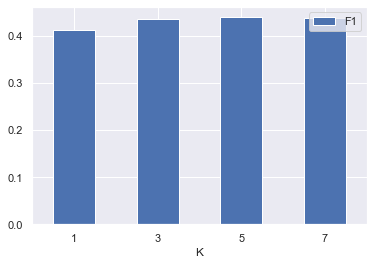

In [240]:
# Plot the F1 score for different values of K
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,8,2)], "F1":knn_list_scores}).set_index("K").plot.bar(rot=0)
    plt.show()
plot_accuracy(cv_scores)

Performing KNN on the original delay data using 10-fold cross-validation where $K = 1, 3, 5, 7$ shows that $K = 5$ is the optimal number of neighbors for this model, returning an F1 of around 0.45.

#### Undersampled Data without Grid Search

In [241]:
# Source: https://deveshpoojari.medium.com/k-nearest-neighbors-and-its-optimization-2e3f6797af04

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating odd list K for KNN
neighbors = list(range(1,8,2))

# Empty list that will hold cv scores
cv_scores = [ ]

# Perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K,
                               n_jobs = -1)
    scores = cross_val_score(knn,
                             X_train_del_under,
                             y_train_del_under,
                             cv = 10,
                             scoring = "f1_weighted"
                            )
    cv_scores.append(scores.mean())

In [242]:
# Changing to mis-classification error
mse = [1-x for x in cv_scores]

# Determining the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

The optimal no. of neighbors is 7


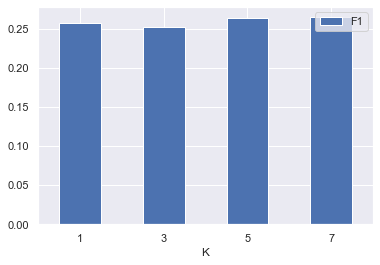

In [243]:
# Plot the F1 score for different values of K
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,8,2)], "F1":knn_list_scores}).set_index("K").plot.bar(rot=0)
    plt.show()
plot_accuracy(cv_scores)

On the undersampled data, KNN with 10-fold cross-validation where $K = 1, 3, 5, 7$ shows that now $K = 7$ is the optimal number of neighbors for this model, but the F1 score has dropped to ~0.29.

#### SMOTE without Grid Search

In [244]:
# Source: https://deveshpoojari.medium.com/k-nearest-neighbors-and-its-optimization-2e3f6797af04

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating odd list K for KNN
neighbors = list(range(1,8,2))

# Empty list that will hold cv scores
cv_scores = [ ]

# Perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K,
                               n_jobs = -1)
    scores = cross_val_score(knn,
                             X_train_del_smote,
                             y_train_del_smote,
                             cv = 10,
                             scoring = "f1_weighted"
                            )
    cv_scores.append(scores.mean())

In [245]:
# Changing to mis-classification error
mse = [1-x for x in cv_scores]

# Determining the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

The optimal no. of neighbors is 1


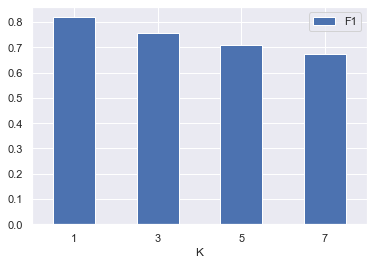

In [246]:
# Plot the F1 score for different values of K
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,8,2)], "F1":knn_list_scores}).set_index("K").plot.bar(rot=0)
    plt.show()
plot_accuracy(cv_scores)

Interestingly, running KNN with the same cross-validation and number of $K’s$, we find that $K = 1$ is the optimal number with an F1 score of slightly above 0.8. This is a similar performance result from SMOTE that we saw with the random forest models.

#### SMOTE with Grid Search

In [224]:
%%time
# # https://realpython.com/knn-python/
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# #Create KNN Classifier
parameters = {
     "n_neighbors": list(range(1,20,2)),
     "weights": ["uniform", "distance"],
 }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, scoring = 'f1_weighted')
gridsearch.fit(X_train_del_smote, y_train_del_smote)
gridsearch.best_params_

Wall time: 1h 10min 25s


{'n_neighbors': 1, 'weights': 'uniform'}

After running a grid search to help select the best parameters, `K = 1` and the `weights = 'uniform'` are chosen for the KNN classfier model using SMOTE. 

In [225]:
test_preds_grid2 = gridsearch.predict(X_test_del_smote)

In [226]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_del_smote, test_preds_grid2))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, test_preds_grid2, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, test_preds_grid2, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, test_preds_grid2, average='weighted')))

Accuracy: 0.8439989486944779
Weighted Precision: 0.84
Weighted Recall: 0.84
Weighted F1-score: 0.83


After running a grid search on the KNN model with SMOTE, this was the best performing model with the lowest amount of neighbors at 1. This performed well with all of the evaluation metrics that were selected in our model. 

In [247]:
#save and run model with K=1 and pull metrics
knn_delay = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn_delay.fit(X_train_del_smote, y_train_del_smote)
y_pred_knn_del = knn_delay.predict(X_test_del_smote)

### 5.2.3 SVM

#### Original Split

In [209]:
%%time

from sklearn.linear_model import SGDClassifier

#Create SVM Classifier
del_svm_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01],
    "random_state": [42]
}

del_svm_grid0 = GridSearchCV(estimator = SGDClassifier(early_stopping=True, class_weight = 'balanced'),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = del_svm_params,
                               cv = 10,
                               scoring = 'f1_weighted')

del_svm_grid0.fit(X_train_del, y_train_del)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


Wall time: 1min 30s


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='f1_weighted', verbose=1)

In [210]:
#print best estimator
print(del_svm_grid0.best_estimator_)

#with its score
print("F1_weighted:",np.abs(del_svm_grid0.best_score_))

SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              penalty='l1', random_state=42)
F1_weighted: 0.19263205910002779


#### Undersample

In [211]:
%%time

from sklearn.linear_model import SGDClassifier

#Create SVM Classifier
del_svm_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01],
    "random_state": [42]
}

del_svm_grid1 = GridSearchCV(estimator = SGDClassifier(early_stopping=True, class_weight = 'balanced'),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = del_svm_params,
                               cv = 10,
                               scoring = 'f1_weighted')

del_svm_grid1.fit(X_train_del_under, y_train_del_under)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.5s finished


Wall time: 43 s


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='f1_weighted', verbose=1)

In [212]:
#print best estimator
print(del_svm_grid1.best_estimator_)

#with its score
print("F1_weighted:",np.abs(del_svm_grid1.best_score_))

SGDClassifier(class_weight='balanced', early_stopping=True, random_state=42)
Accuracy: 0.16431898290636254


#### SMOTE

In [213]:
%%time

from sklearn.linear_model import SGDClassifier

#Create SVM Classifier
del_svm_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01],
    "random_state": [42]
}

del_svm_grid2 = GridSearchCV(estimator = SGDClassifier(early_stopping=True, class_weight = 'balanced'),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = del_svm_params,
                               cv = 10,
                               scoring = 'f1_weighted')

del_svm_grid2.fit(X_train_del_smote,y_train_del_smote)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.5min finished


Wall time: 4min 39s


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='f1_weighted', verbose=1)

In [214]:
#print best estimator
print(del_svm_grid2.best_estimator_)

#with its score
print("F1_weighted:",np.abs(del_svm_grid2.best_score_))


SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              penalty='l1', random_state=42)
F1_weighted: 0.17970411243679513


Similar to our cancellation modelling, SGDClassifier does not perform well on the delay data.

## 6. Modeling and Evaluation 4

### 6.2 Delay Data

| Model Type | Data set| Test F1 | Precision | Recall
| --- | --- | --- | --- | --- |
| Random Forest | Orginal | 0.53 | 0.55 | 0.58
| Random Forest | Undersampled | 0.44 | 0.49 | 0.49
| Random Forest | SMOTE | 0.72 | 0.72 | 0.72
| KNN | SMOTE | 0.83 | 0.84 | 0.84


Our best performing model types were random forest and KNN using the SMOTE split. Of these, the best in terms of F1 score, precision, and recall was the KNN model with an F1 score on the test set of 0.83. We will visualize some of these results via confusion matrices below, where we would expect a good performing model to have the darkest blue colors along the diagonal. This indicates a higher accuracy in terms of predicted class.

### 7.2 Delay Data Model Comparison

For our delay data, while KNN with SMOTE is our best performing model, we chose to focus on Random Forest with SMOTE for feature importance as we do not have coefficients or importances from KNN. The features most important are below.

In [208]:
#feature important for RF on SMOTE data - delays

features_del = df_delay.iloc[:,:-1]

feature_imp_del = pd.Series(rf.feature_importances_,index=features_del.columns).sort_values(ascending=False)
#show top 5
feature_imp_del[0:5]

TAIL_NUMBER_encode            0.076024
FLIGHT_NUMBER                 0.070683
TAXI_OUT                      0.065760
SCHEDULED_TIME                0.065471
DESTINATION_AIRPORT_encode    0.061690
dtype: float64

In terms of delay, weather did not make the top five important features. Instead, `TAIL_NUMBER_encode` (which is our encoded variable for the plane) showed as the most important followed closely by `FLIGHT_NUMBER`. Typically, one plane will fly the same route multiple times which is why it would make sense that the `FLIGHT_NUMBER` would be almost as important as the plane flying it. `TAXI_OUT` suggests congestion at the airport for take off which would lead to departure delays. `SCHEDULED_TIME` and `DESTINATION_AIRPORT_encode` suggest that based on destination, a departure delay is more likely to occur.

# Deployment
Jump to [top](#Rubric)

# Exceptional Work
Jump to [top](#Rubric)